2018 Oct 17<br>
In Analyzing_Kepler76b_with_LM.ipynb, some of the variability in the eclipse seems to coincide with the gaps in the time-series. In this notebook, I'm going to explore whether having gaps creates variability somehow.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit

from lightkurve import KeplerLightCurveFile
from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

from transit_utils import bindata, transit_duration, supersample_time
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

K76 = Kepler76_params()

In [2]:
num_period = 2
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

158.5868291130012


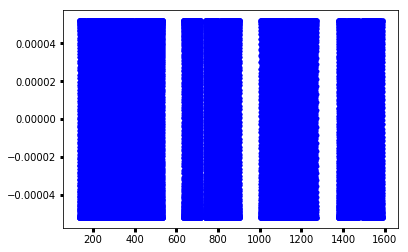

In [3]:
def fit_eclipse_and_BEER_signals(time, baseline, eclipse_depth, Aellip, Aplanet, phase_shift,
                        transit_params=K76, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = K76.saved_params['per']
    ma['a'] = K76.saved_params['a']
    ma['T0'] = K76.saved_params['T0'] + 0.5*K76.saved_params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(K76.saved_params['b']/K76.saved_params['a'])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
    params['per'] = K76.saved_params['per']
    params['baseline'] = 0.
    params['Aellip'] = Aellip
    params['Abeam'] = K76.saved_params['Abeam']
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = K76.saved_params['a']
    params['T0'] = K76.saved_params['T0']
    params['i'] = np.arccos(K76.saved_params['b']/K76.saved_params['a'])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

initial_guess = [0., 0., 0.,
                 K76.saved_params['Aplanet'], 0.]
plt.plot(filtered_time, fit_eclipse_and_BEER_signals(filtered_time, *initial_guess), 'b.')

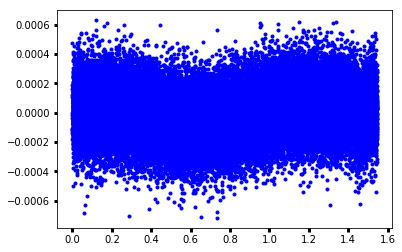

In [4]:
parameters = [0., 100e-6, K76.saved_params['Aellip'], K76.saved_params['Aplanet'], 
              K76.saved_params['phase_shift']]

synthetic_signal = fit_eclipse_and_BEER_signals(filtered_time, *parameters)
noisy_synthetic_signal = synthetic_signal + normal(scale=unbinned_noise, size=len(filtered_time))

plt.plot(folded_time, noisy_synthetic_signal, 'b.')

In [42]:
#baseline, eclipse_depth, Aellip, Aplanet, phase_shift

num_periods_to_fold = 10.

# orbit_times = {}
# best_fit_params = {}
# best_fit_params_uncertainties = {}

# orbit_times[num_periods_to_fold] = [0.]

# bounds = ([-1000e-6, -1000e-6, -500e-6, -500e-6, -1], 
#           [1000e-6, 1000e-6, 500e-6, 500e-6, 1])
# initial_guess = [0., 100e-6, K76.saved_params['Aellip'], K76.saved_params['Aplanet'], 0.]
# best_fit_params[num_periods_to_fold] = initial_guess
# best_fit_params_uncertainties[num_periods_to_fold] = initial_guess

# mn = np.min(filtered_time)
# mx = np.min(filtered_time) + num_periods_to_fold*K76.saved_params['per']

# while(mx <= np.max(filtered_time) - num_periods_to_fold*K76.saved_params['per']):
    
#     # Next orbit's data, minus the transit portion    
#     ind = ((filtered_time >= mn) & (filtered_time < mx))
#     unfolded_time = filtered_time[ind]
#     time = folded_time[ind]
#     data = noisy_synthetic_signal[ind]
#     err = unbinned_noise*np.ones_like(time)
    
#     out_of_transit_ind = ~transit_indices(time, 3.*K76.dur, K76.saved_params['T0'])
#     unfolded_time = unfolded_time[out_of_transit_ind]
#     time = time[out_of_transit_ind]
#     data = data[out_of_transit_ind]
#     err = err[out_of_transit_ind]
        
#     if(time.size >= np.floor(num_periods_to_fold/2*K76.saved_params['per']/(30./60./24.))):
#         cur_orbit_time = np.mean(unfolded_time)
#         popt, pcov = curve_fit(fit_eclipse_and_BEER_signals, time, data, sigma=err, 
#                                p0=initial_guess, bounds=bounds)
#         uncertainties = np.sqrt(pcov.diagonal())

#         # Rescale uncertainties
#         redchisq = redchisqg(data, fit_eclipse_and_BEER_signals(time, *popt), 2, err)
# #         print(popt)
# #         print(uncertainties)
# #         binned_time, binned_data, binned_err = bindata(time, data, 10./60./24.)
# #         plt.plot(binned_time, binned_data, 'b.')
# #         plt.plot(time, fit_eclipse_and_BEER_signals(time, *popt), 'r.')
# #         break

#         orbit_times[num_periods_to_fold] =\
#             np.append(orbit_times[num_periods_to_fold], cur_orbit_time)
#         best_fit_params[num_periods_to_fold] = np.vstack((best_fit_params[num_periods_to_fold], popt))
#         best_fit_params_uncertainties[num_periods_to_fold] =\
#             np.vstack((best_fit_params_uncertainties[num_periods_to_fold], 
#                       uncertainties))
            
#     mn += K76.saved_params['per']
#     mx += K76.saved_params['per']
  
#baseline, eclipse_depth, Aellip, Aplanet, phase_shift

fig = plt.figure(figsize=(10,10))

which_param = 3
x = orbit_times[num_periods_to_fold][1:]
y = best_fit_params[num_periods_to_fold][1:,which_param]
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,which_param]
ind = (np.abs(y/yerr) > 0.)
#plt.plot(x[ind], (y[ind] - np.mean(y[ind]))/yerr[ind], marker='.', ls='')

med_ind = (y == np.median(y))
plt.plot(x[ind], (y[ind] - np.median(y))/np.sqrt(yerr[ind]**2 + yerr[med_ind]**2.), marker='.', ls='')
# print(np.max(np.abs((y[ind] - np.median(y))/np.sqrt(yerr[ind]**2 + yerr[med_ind]**2.))))

#plt.errorbar(x[ind], y[ind], yerr[ind], marker='.', ls='')

#fig.savefig("Gaps_in_Time-Series_10-orbs.png", dpi=500, bbox_inches="tight")

ValueError: operands could not be broadcast together with shapes (712,) (0,) 

<Figure size 720x720 with 0 Axes>